In [1]:
import time
import os

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=6, suppress=True)

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.__version__

'2.3.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

## Model training

### hyperparameters

In [6]:
BATCH_SIZE = 64
IMG_HEIGHT = 512
IMG_WIDTH = 512
BEST_PATH = './models/best_conv_C.h5'

### Data loading

In [7]:
weight_df = pd.read_csv('./results/weight_reg.csv', index_col='Unnamed: 0')

In [8]:
weight_df.index = pd.date_range('2020-02-25', '2020-07-13', freq='1d')
weight_df.index = pd.DatetimeIndex(weight_df.index)

In [9]:
MAX = weight_df.max().values[0]
MIN = weight_df.min().values[0]

In [10]:
weight_df = (weight_df - MIN)/(MAX - MIN)

In [11]:
DIRECTORY = './data/train/'
dir_list = os.listdir(DIRECTORY)
dataset_list = [direc for direc in dir_list if direc.startswith('d_')]
dataset_list.sort()

In [12]:
input_images = []
output_labels = []
for SUBDIR in dataset_list:
    date = SUBDIR.split('_')[-1]
    date = pd.datetime(2020, int(date[:2]), int(date[2:]))
    
    file_list = os.listdir(DIRECTORY + SUBDIR)
    file_list = [file for file in file_list if file.endswith('.jpg')]
    for FILE in file_list:
        image = Image.open(DIRECTORY + SUBDIR + '/' + FILE)
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        input_images.append(img_to_array(image))
        
        output_labels.append(weight_df.loc[date].values[0])

In [13]:
input_images = np.stack(input_images, axis=0)
output_labels = np.stack(output_labels, axis=0).reshape(-1, 1)

In [14]:
data_index = np.arange(0, output_labels.shape[0]).reshape(-1, 1)

In [15]:
data_index, input_images, output_labels = shuffle(data_index, input_images, output_labels)

In [16]:
num_train = int(input_images.shape[0]*.7)

In [17]:
train_input = input_images[:num_train, ...]
train_label = output_labels[:num_train, ...]
test_input = input_images[num_train:, ...]
test_label = output_labels[num_train:, ...]

In [18]:
datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [19]:
train_iterator = datagen.flow(train_input, train_label, batch_size=BATCH_SIZE)
test_iterator = datagen.flow(test_input, test_label, batch_size=BATCH_SIZE)

In [20]:
model = Sequential([
    layers.Conv2D(32, 2, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(1024, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
    ])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       1

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=BEST_PATH,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [24]:
epochs=1000
history = model.fit(
    train_iterator,
    validation_data=test_iterator,
    callbacks=callbacks,
    epochs=epochs
    )

Epoch 1/1000
70/70 [==============================] - ETA: 0s - loss: 0.3866
Epoch 00001: val_loss improved from inf to 0.06473, saving model to ./models/best_conv_C.h5
70/70 [==============================] - 374s 5s/step - loss: 0.3866 - val_loss: 0.0647
Epoch 2/1000
70/70 [==============================] - ETA: 0s - loss: 0.0446
Epoch 00002: val_loss improved from 0.06473 to 0.03791, saving model to ./models/best_conv_C.h5
70/70 [==============================] - 372s 5s/step - loss: 0.0446 - val_loss: 0.0379
Epoch 3/1000
70/70 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00003: val_loss improved from 0.03791 to 0.02130, saving model to ./models/best_conv_C.h5
70/70 [==============================] - 372s 5s/step - loss: 0.0295 - val_loss: 0.0213
Epoch 4/1000
70/70 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00004: val_loss did not improve from 0.02130
70/70 [==============================] - 371s 5s/step - loss: 0.0237 - val_loss: 0.0252
Epoch

In [25]:
trained_model = tf.keras.models.load_model(BEST_PATH)
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       1

In [26]:
pred_result = trained_model.predict(test_input/255)

In [27]:
print(pred_result.shape)
print(test_label.shape)

(1913, 1)
(1913, 1)


[0, 2000, 0, 2000]

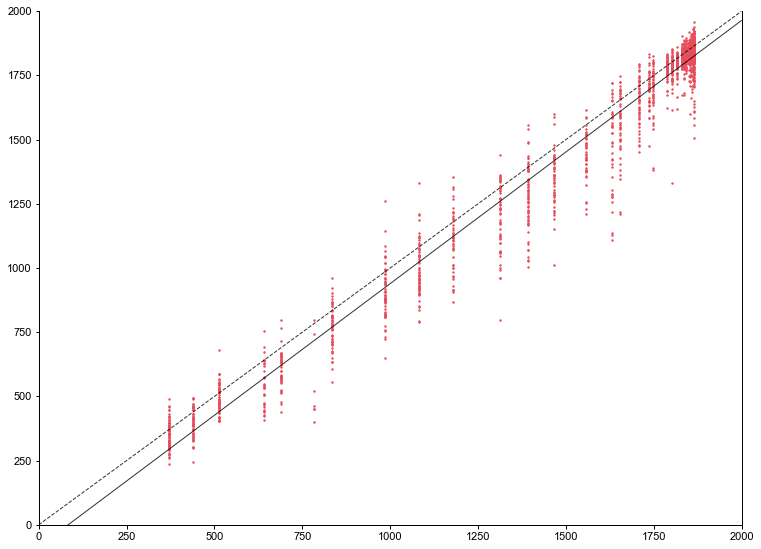

In [28]:
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))

x_linear = np.arange(0, 2000)
y_linear = x_linear
regr = linear_model.LinearRegression()
regr.fit(((MAX-MIN)*test_label + MIN).reshape(-1, 1), ((MAX-MIN)*pred_result + MIN).reshape(-1, 1))
Yp = regr.predict(((MAX-MIN)*test_label + MIN).reshape(-1, 1))
reg_x = np.arange(0, 2000).reshape(-1, 1)
reg_y = reg_x*regr.coef_ + regr.intercept_

plt.plot(x_linear, y_linear, 'k--', linewidth=1, alpha=0.8)
plt.plot(reg_x, reg_y, 'k-', linewidth=1, alpha=0.8)
plt.scatter((MAX-MIN)*test_label + MIN, (MAX-MIN)*pred_result + MIN, c=cmap[0], s=2)
plt.axis([0,2000,0,2000])

In [29]:
final_output = np.concatenate([((MAX-MIN)*test_label + MIN), ((MAX-MIN)*pred_result + MIN)], axis=1)
final_output = pd.DataFrame(final_output, columns=['FW_label', 'FW_pred'])

In [30]:
f = open('./results/test_input_C.npz', 'wb')
np.savez(f,
         test_input = test_input
        )
f.close()

In [31]:
final_output.to_csv('./results/final_output_C.csv')